In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.pipeline import make_pipeline


import statsmodels.api as sm 
from scipy import stats

from sklearn.preprocessing import QuantileTransformer, quantile_transform

In [3]:
# drop unneccessary columns, and create total square foot column, and price per square foot. 

df = pd.read_csv('/Users/sammarcustaylor/Desktop/kc_final.csv')
df.drop(columns = ['Unnamed: 0', 'id', 'date', 'sqft_living15', 'sqft_lot15', 'lat', 'long', 'zipcode'], inplace = True)
sq_ft_sum = df['sqft_living']+ df['sqft_lot']+df['sqft_above']+df['sqft_basement']
df['sqft_total']= sq_ft_sum
df['price_per_sqft'] = df['price']/df['sqft_total']

In [4]:
df

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0      221900.0         3       1.00         1180      5650     1.0   
1      538000.0         3       2.25         2570      7242     2.0   
2      180000.0         2       1.00          770     10000     1.0   
3      604000.0         4       3.00         1960      5000     1.0   
4      510000.0         3       2.00         1680      8080     1.0   
...         ...       ...        ...          ...       ...     ...   
21608  360000.0         3       2.50         1530      1131     3.0   
21609  400000.0         4       2.50         2310      5813     2.0   
21610  402101.0         2       0.75         1020      1350     2.0   
21611  400000.0         3       2.50         1600      2388     2.0   
21612  325000.0         2       0.75         1020      1076     2.0   

       waterfront  view  condition  grade  sqft_above  sqft_basement  \
0               0     0          3      7        1180              0   
1               0     0          3      7        2170            400   
2               0     0          3      6         770              0   
3               0     0          5      7        1050            910   
4               0     0          3      8        1680              0   
...           ...   ...        ...    ...         ...            ...   
21608           0     0          3      8        1530              0   
21609           0     0          3      8        2310              0   
21610           0     0          3      7        1020              0   
21611           0     0          3      8        1600              0   
21612           0     0          3      7        1020              0   

       yr_built  yr_renovated  sqft_total  price_per_sqft  
0          1955             0        8010       27.702871  
1          1951          1991       12382       43.450170  
2          1933             0       11540       15.597920  
3          1965             0        8920       67.713004  
4          1987             0       11440       44.580420  
...         ...           ...         ...             ...  
21608      2009             0        4191       85.898354  
21609      2014             0       10433       38.339883  
21610      2009             0        3390      118.613864  
21611      2004             0        5588       71.581961  
21612      2008             0        3116      104.300385  

[21613 rows x 16 columns]

The View column values span from 0-4, and it represents a problem with our algorithm as it allows the linear regression model to have disproportionate ratings when predicting the price in regards to the view variable. Year renovated may also pose some issues with the model considering large numbers. Will come back and check....

In [5]:
df['view'].value_counts()

0    19489
2      963
3      510
1      332
4      319
Name: view, dtype: int64

In [6]:
view = df['view'].replace([2,3,4],1)
df['view'] = view
df['view'].value_counts()

0    19489
1     2124
Name: view, dtype: int64

No null values in the dataframe and we are good to fit an initial model.

In [8]:
df.isnull().values.any()

False

# Fit an Initial Linear Regresion Model 

In [9]:
pipe = make_pipeline(LinearRegression())

In [10]:
ridge = Ridge(alpha = 10).fit(X_train, y_train)
parameters = {'alpha' : [.001, .01, 1, 100, 1000]}


cv = GridSearchCV(ridge, parameters, cv = 5, verbose = 2)
cv.fit(X_train, y_train.values.ravel())


print_results(cv)

NameError: name 'X_train' is not defined

In [11]:
y = df['price'] 
X = df.drop(['price'], axis = 1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [13]:
lr = LinearRegression().fit(X_train, y_train)

We are presented with an initial score .79 which tells us that this is a formidable dataset for linear regression. 
Our independent variables represent 79% of the explained variation in home prices. 

In [14]:
print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))

Training set score: 0.79
Test set score: 0.79


# Analyzing Coefficients 

In [15]:
coef = lr.coef_
intercept = lr.intercept_
coef = coef.reshape([15,])

coef_df = pd.DataFrame(coef, X.columns, columns = ['Coeff Values'])

In [16]:
coef_df

Coeff Values
bedrooms        -16658.328368
bathrooms         8377.622598
sqft_living         61.992292
sqft_lot           -61.565435
floors         -155622.261443
waterfront      558868.325183
view             70456.881257
condition        15751.563104
grade            53652.556586
sqft_above          92.448280
sqft_basement      -30.455988
yr_built         -1595.167515
yr_renovated        16.392486
sqft_total          62.419148
price_per_sqft    5741.657156

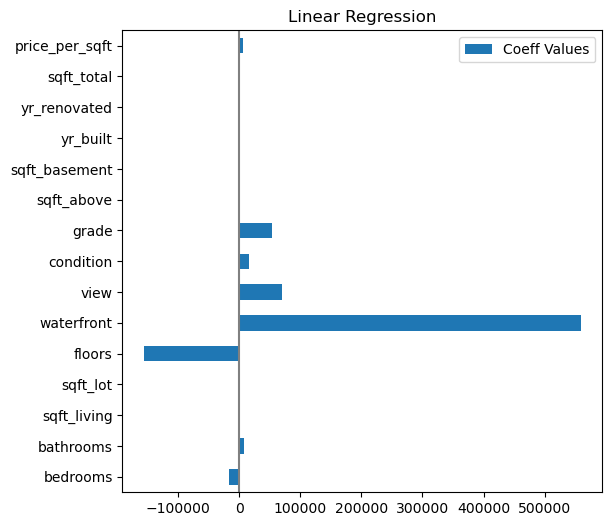

In [17]:
coef_df.plot(kind = 'barh', figsize = (8, 6))
plt.title('Linear Regression')
plt.axvline(x = 0, color = '.5')
plt.subplots_adjust(left = 0.3)

# Continuous Indepenent Features in Relation to Dependent Price

In [18]:
# select all continuous variables, and plot them against the dependent variables price.  

cont_features = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot','sqft_above',
       'sqft_basement', 'sqft_total',
       'price_per_sqft']

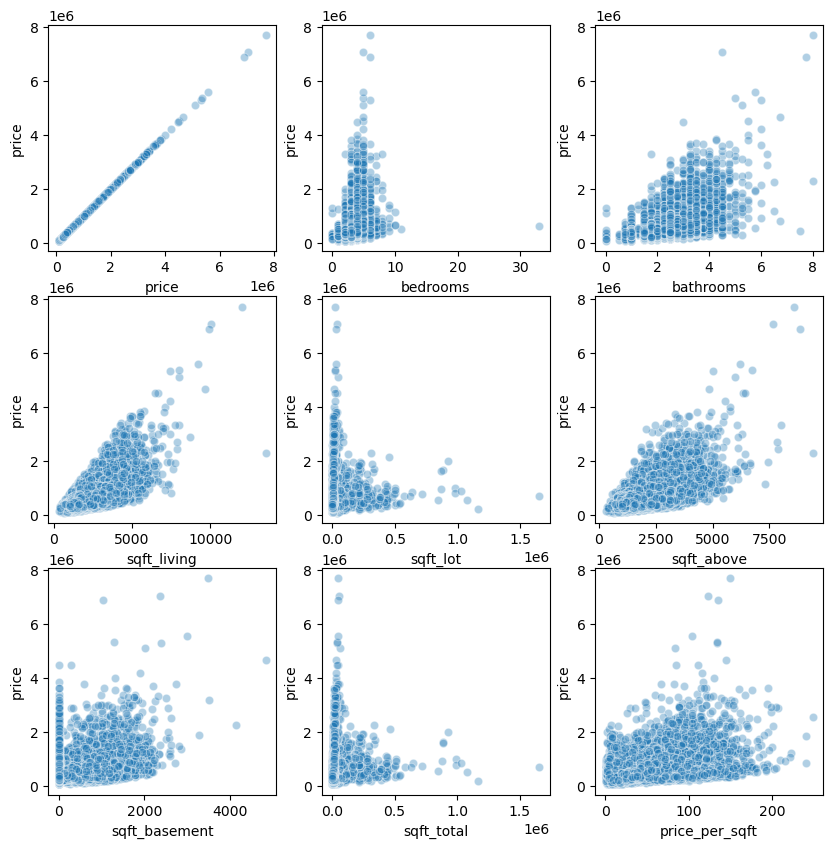

In [19]:
plt.figure(figsize = (10, 10))
for i in enumerate(cont_features):
    plt.subplot(3,3, i[0]+1)
    sns.scatterplot(i[1], y = df['price'], data = df, alpha = .35)

# Categorical Independent Features in Relation to Price 

In [217]:
cont_features = ['floors', 'waterfront', 'view', 'condition', 'grade']

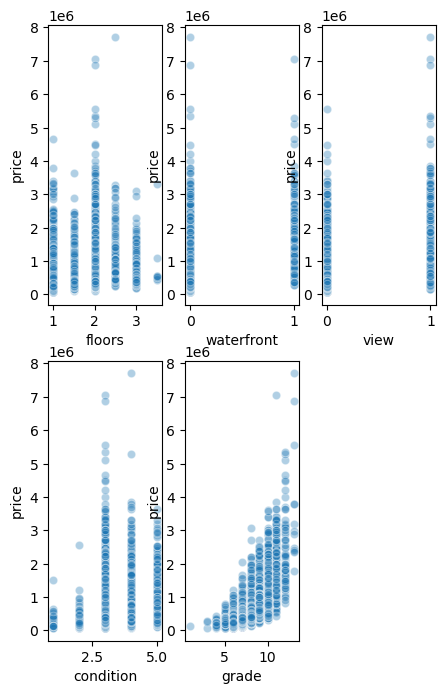

In [221]:
plt.figure(figsize = (5, 8))
for i in enumerate(cont_features):
    plt.subplot(2,3, i[0]+1)
    sns.scatterplot(i[1], y = df['price'], data = df, alpha = .35)

# Test

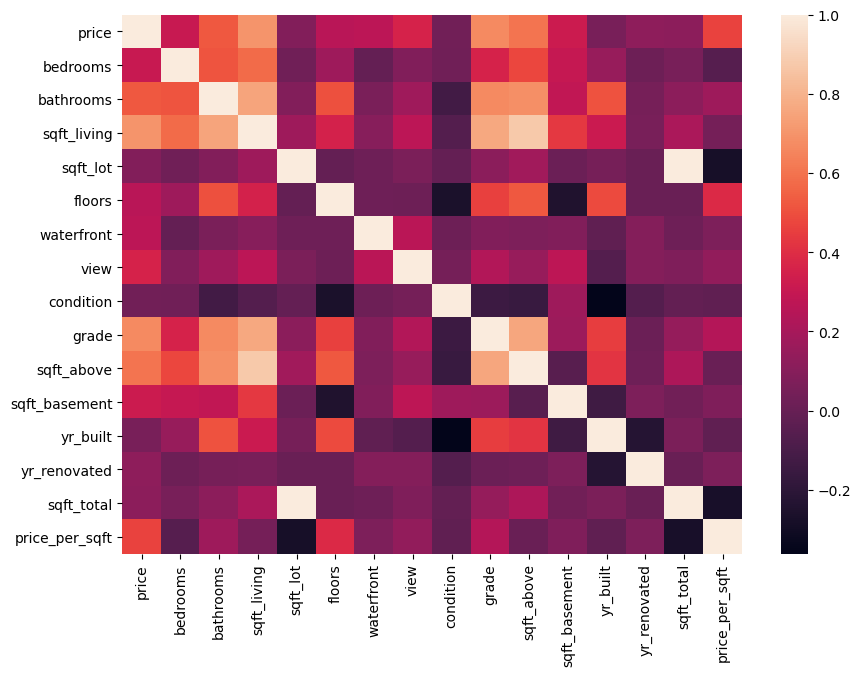

In [276]:
fig_dims = (10,7)
fig, ax = plt.subplots(figsize = fig_dims)
sns.heatmap(df.corr(), ax = ax)
plt.show()

In [277]:
abs(df.corr()['price'])

price            1.00
bedrooms         0.31
bathrooms        0.53
sqft_living      0.70
sqft_lot         0.09
floors           0.26
waterfront       0.27
view             0.36
condition        0.04
grade            0.67
sqft_above       0.61
sqft_basement    0.32
yr_built         0.05
yr_renovated     0.13
sqft_total       0.12
price_per_sqft   0.47
Name: price, dtype: float64

In [279]:
abs(df.corr()['price'][abs(df.corr()['price'])>0.5].drop('price')).index.tolist()

['bathrooms', 'sqft_living', 'grade', 'sqft_above']

In [ ]:
# function to run through train test split 

In [ ]:
vals = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

for val in vals:
    features = abs(df.corr()['price'][abs(df.corr()['price'])> val].drop('price')).index.tolist()
    
    X = boston.drop(columns = 'price')
    X = X[features]
    
    print(features)
    
    
    lr = lr.fit(X_train, y_train)
    parameters = {'alpha' : [.001, .01, 1, 100, 1000]}


    cv = GridSearchCV(ridge, parameters, cv = 5, verbose = 2)
    cv.fit(X_train, y_train.values.ravel())


    print_results(cv)



In [288]:
df_2

price  bedrooms  sqft_lot  floors  waterfront  view  condition  \
0     221900.00         3      5650    1.00           0     0          3   
1     538000.00         3      7242    2.00           0     0          3   
2     180000.00         2     10000    1.00           0     0          3   
3     604000.00         4      5000    1.00           0     0          5   
4     510000.00         3      8080    1.00           0     0          3   
...         ...       ...       ...     ...         ...   ...        ...   
21608 360000.00         3      1131    3.00           0     0          3   
21609 400000.00         4      5813    2.00           0     0          3   
21610 402101.00         2      1350    2.00           0     0          3   
21611 400000.00         3      2388    2.00           0     0          3   
21612 325000.00         2      1076    2.00           0     0          3   

       sqft_basement  yr_built  yr_renovated  sqft_total  price_per_sqft  
0                  0      1955             0        8010           27.70  
1                400      1951          1991       12382           43.45  
2                  0      1933             0       11540           15.60  
3                910      1965             0        8920           67.71  
4                  0      1987             0       11440           44.58  
...              ...       ...           ...         ...             ...  
21608              0      2009             0        4191           85.90  
21609              0      2014             0       10433           38.34  
21610              0      2009             0        3390          118.61  
21611              0      2004             0        5588           71.58  
21612              0      2008             0        3116          104.30  

[21613 rows x 12 columns]

In [284]:
y = df_2['price'] 
X = df_2.drop(['price'], axis = 1)

In [285]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [286]:
lr = LinearRegression().fit(X_train, y_train)

In [287]:
print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))

Training set score: 0.78
Test set score: 0.78


In [66]:
# X.var()

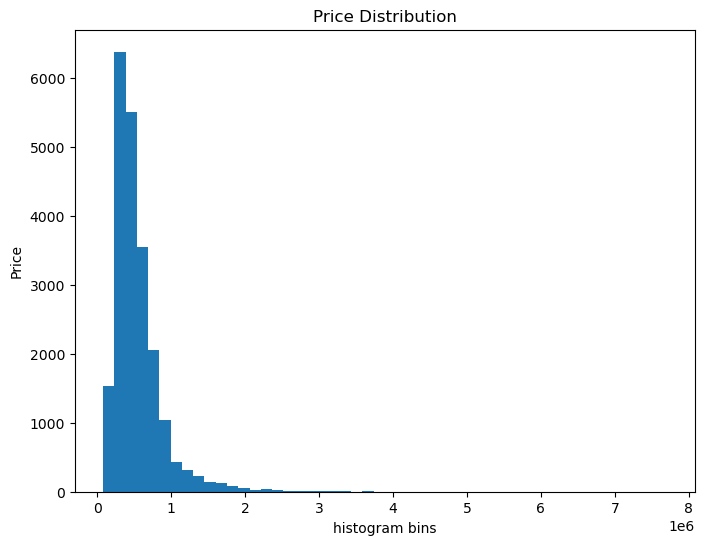

In [384]:
# target variable distribution is skewed 

df['price'].plot(kind='hist', figsize=(8,6), bins=50)
plt.title('Price Distribution')
plt.xlabel('histogram bins')
plt.ylabel('Price');

In [335]:
y_trans = quantile_transform(y.to_frame(), n_quantiles = 900, output_distribution = 'normal', copy = True).squeeze()

In [336]:
y2 = pd.DataFrame(y_trans, columns = ['price'])

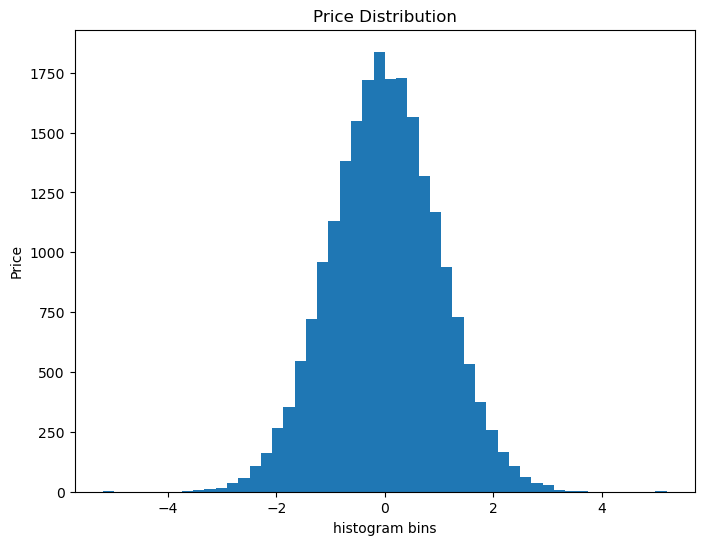

In [337]:
y2['price'].plot(kind='hist', figsize=(8,6), bins=50)
plt.title('Price Distribution')
plt.xlabel('histogram bins')
plt.ylabel('Price');

In [338]:
X_train, X_test, y_train, y_test = train_test_split(X, y2, random_state = 42)

The function code below was taken from

Jedamski, D (2021) Applied Machine Learning: Foundations [Source code]. https://www.linkedin.com/learning/applied-machine-learning-foundations/leveraging-machine-learning?u=56744785 

In [289]:
import warnings
warnings.filterwarnings('ignore', category = FutureWarning)
warnings.filterwarnings('ignore', category = DeprecationWarning)

def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))
    
    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [340]:
# lr = LinearRegression()
ridge = Ridge(alpha = 10).fit(X_train, y_train)
parameters = {'alpha' : [.001, .01, 1, 100, 1000]}


cv = GridSearchCV(ridge, parameters, cv = 5, verbose = 2)
cv.fit(X_train, y_train.values.ravel())


print_results(cv)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ........................................

/Users/sammarcustaylor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.25855e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/sammarcustaylor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.58036e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


[CV] END ..........................................alpha=100; total time=   0.0s
[CV] END ..........................................alpha=100; total time=   0.0s
[CV] END ..........................................alpha=100; total time=   0.0s
[CV] END ..........................................alpha=100; total time=   0.0s
[CV] END .........................................alpha=1000; total time=   0.0s
[CV] END .........................................alpha=1000; total time=   0.0s
[CV] END .........................................alpha=1000; total time=   0.0s
[CV] END .........................................alpha=1000; total time=   0.0s
[CV] END .........................................alpha=1000; total time=   0.0s
BEST PARAMS: {'alpha': 1}

0.761 (+/-0.009) for {'alpha': 0.001}
0.761 (+/-0.009) for {'alpha': 0.01}
0.761 (+/-0.009) for {'alpha': 1}
0.761 (+/-0.009) for {'alpha': 100}
0.759 (+/-0.008) for {'alpha': 1000}


In [341]:
lr = LinearRegression().fit(X_train, y_train)
print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))

Training set score: 0.76
Test set score: 0.76


In [342]:
y_pred = lr.predict(X_train)

In [363]:
coef = lr.coef_

# Check Coefficients 

In [364]:
X.columns.shape

(15,)

# KC Housing Calculator

In [369]:


# pred1 = (lr.intercept_) + (coef_df.loc['CHAS'][0] * 1) * (coef_df.loc['AGE'][0] * AGE) * (coef_df.loc['LSTAT'][0] * LSTAT) * (coef_df.loc['RM'][0]* RM) 

In [372]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     6157.
Date:                Mon, 25 Oct 2021   Prob (F-statistic):               0.00
Time:                        23:00:01   Log-Likelihood:            -2.9087e+05
No. Observations:               21613   AIC:                         5.818e+05
Df Residuals:                   21599   BIC:                         5.819e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.571e+06   1.12e+05     22.

# Residuals Plot

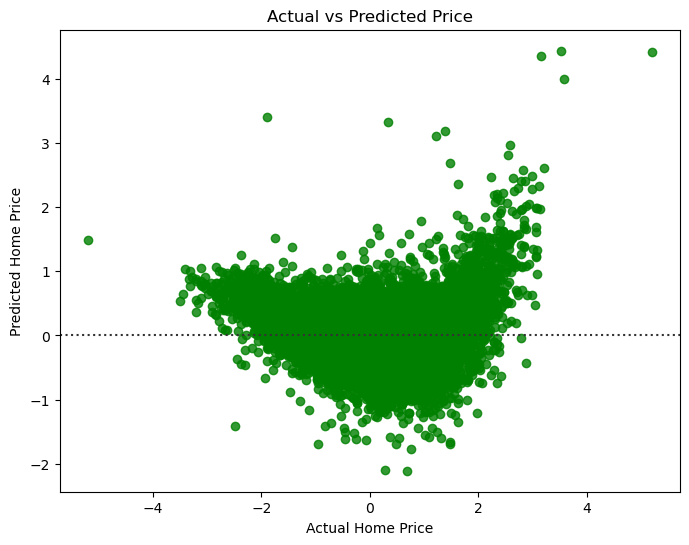

In [373]:
plt.figure(figsize = (8,6))

sns.residplot( y_train, y_pred, color = 'green')
plt.xlabel('Actual Home Price')
plt.ylabel('Predicted Home Price')
plt.title('Actual vs Predicted Price');

# Dropping Independent Variables Based on Correlation 

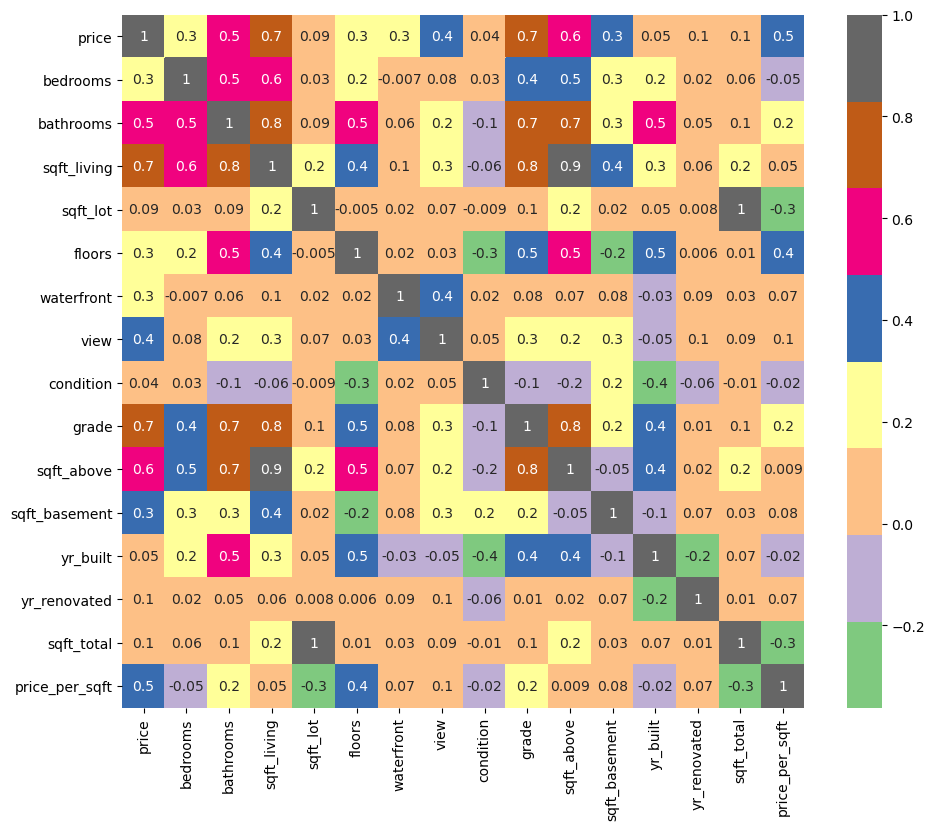

In [268]:
plt.figure(figsize = (11, 9))
cor = df.corr()
sns.heatmap(cor, annot = True,fmt='.1g', cmap = plt.cm.Accent)
plt.show()

In [269]:
def correlation(dataset, threshold):
    col_corr = set()  # set all of the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:   #absolute coeff value is an option 
                colname = corr_matrix.columns[i] # getting the name of the column
                col_corr.add(colname)
    return col_corr

In [270]:
corr_features = correlation(X_train, 0.80)
corr_features

{'sqft_above', 'sqft_total'}

In [271]:
X_train_2 = X_train.drop(corr_features, axis = 1)
X_test_2 = X_test.drop(corr_features, axis = 1)

Dropping independent variables based off of high correlation scores in order to combat multicollinearity.
This proves to not work as training and test set scores are stagnant from original model. 

In [272]:
ridge = Ridge(alpha = 0.1).fit(X_train_2, y_train)

In [273]:
lr = LinearRegression().fit(X_train_2, y_train)
print("Training set score: {:.2f}".format(lr.score(X_train_2, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test_2, y_test)))

print('\n')

print("Ridge Training set score: {:.2f}".format(ridge.score(X_train_2, y_train)))
print("Ridge Test set score: {:.2f}".format(ridge.score(X_test_2, y_test)))

Training set score: 0.79
Test set score: 0.79


Ridge Training set score: 0.79
Ridge Test set score: 0.79


In [57]:
# display linear relationships through a correlation plot 
# x_axis_labels = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition','grade','sqft_above','sqft_basement','yr_built','yr_renovated', 'sqft_total', 'price_per_sqft'] # labels for x-axis
# y_axis_labels = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition','grade','sqft_above','sqft_basement','yr_built','yr_renovated', 'sqft_total', 'price_per_sqft']


# cm = np.corrcoef(df.values.T)
# plt.subplots(figsize=(20,10))
# sns.set(font_scale=1)
# hm = sns.heatmap(cm,
#                 cbar=True,
#                 square=True,
#                 fmt='.2f',
#                 annot = True, 
#                 xticklabels=x_axis_labels, 
#                 yticklabels=y_axis_labels)

In [210]:
# need to narrow the pairplot down 

train_dataset = X_train.copy()

train_dataset

bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
5945          4       2.25         1810      9240     2.0           0     0   
8423          3       2.50         1600      2788     2.0           0     0   
13488         4       2.50         1720      8638     2.0           0     0   
20731         2       2.25         1240       705     2.0           0     0   
2358          3       2.00         1280     13356     1.0           0     0   
...         ...        ...          ...       ...     ...         ...   ...   
11964         3       1.50         1000      6914     1.0           0     0   
21575         3       2.50         3087      5002     2.0           0     0   
5390          3       2.50         2120      4780     2.0           0     0   
860           1       0.75          380     15000     1.0           0     0   
15795         4       2.50         3130      5999     2.0           0     0   

       condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
5945           3      7        1810              0      1961             0   
8423           4      7        1600              0      1992             0   
13488          3      8        1720              0      1994             0   
20731          3      7        1150             90      2009             0   
2358           3      7        1280              0      1994             0   
...          ...    ...         ...            ...       ...           ...   
11964          3      7        1000              0      1947             0   
21575          3      8        3087              0      2014             0   
5390           3      7        2120              0      2004             0   
860            3      5         380              0      1963             0   
15795          3      7        3130              0      2006             0   

       sqft_total  price_per_sqft  
5945        12860       20.889813  
8423         5988       40.915164  
13488       12078       16.559033  
20731        3185      110.674725  
2358        15916       14.576527  
...           ...             ...  
11964        8914       42.405205  
21575       11176       35.786507  
5390         9020       63.747228  
860         15760       15.545685  
15795       12259       25.695407  

[16209 rows x 15 columns]

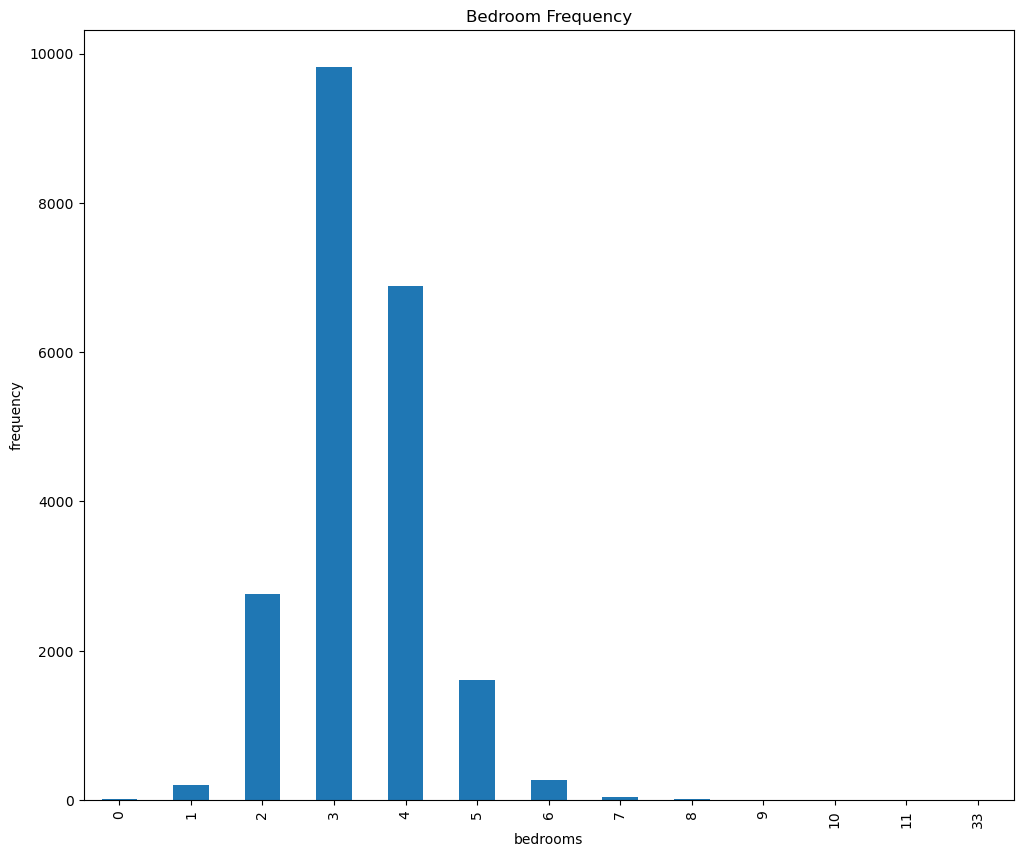

In [11]:
# find the frequencies of bedrooms and bathrooms. 
# confirm normal distributions. 

bedroom_freq = df.groupby('bedrooms')['bedrooms'].agg('count')
bathroom_freq = df.groupby('bathrooms')['bathrooms'].agg('count')

bedroom_freq.plot(kind = 'bar', title = 'Bedroom Frequency', figsize = (12,10))
plt.xlabel('bedrooms')
plt.ylabel('frequency');

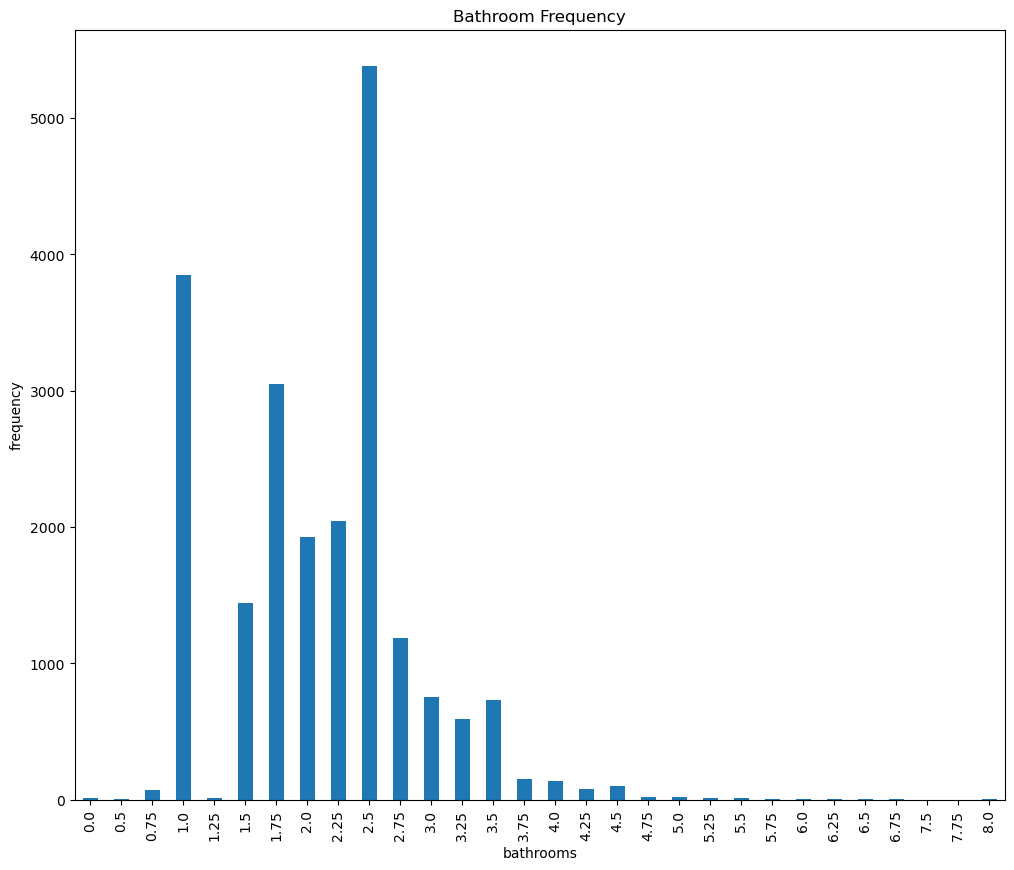

In [12]:
bathroom_freq.plot(kind = 'bar', title = 'Bathroom Frequency', figsize = (12,10))
plt.xlabel('bathrooms')
plt.ylabel('frequency');

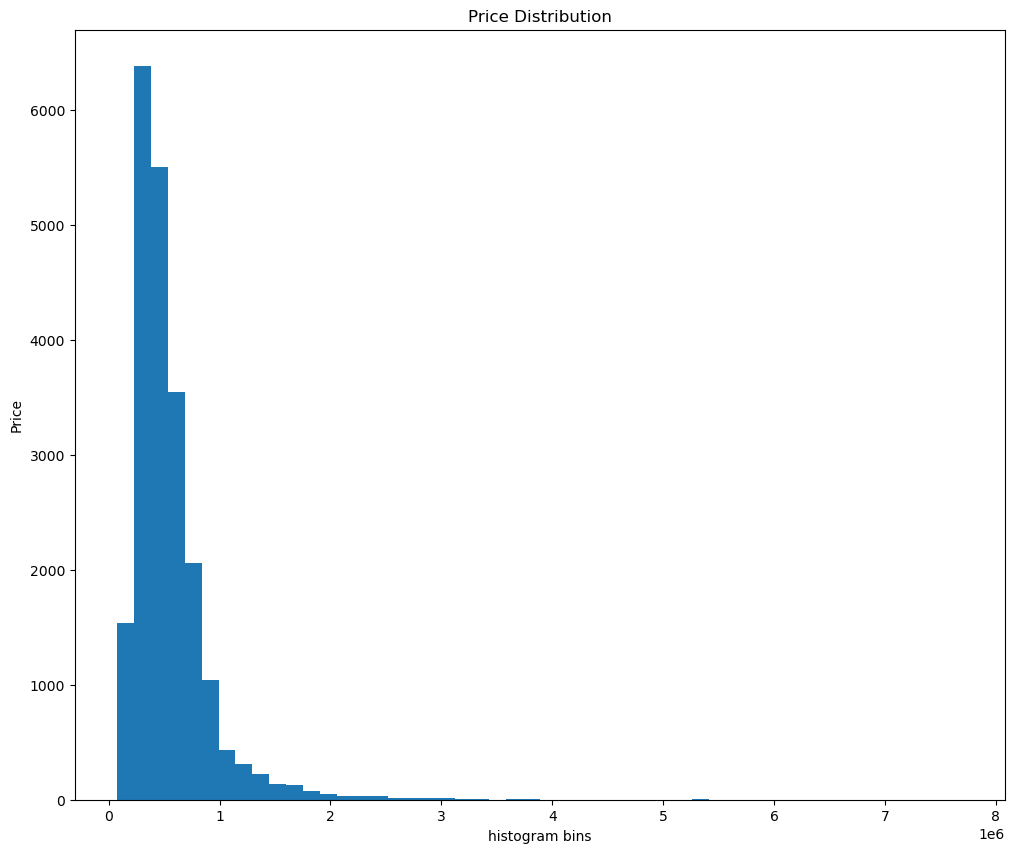

In [13]:
df['price'].plot(kind='hist', figsize=(12,10), bins=50)
plt.title('Price Distribution')
plt.xlabel('histogram bins')
plt.ylabel('Price');

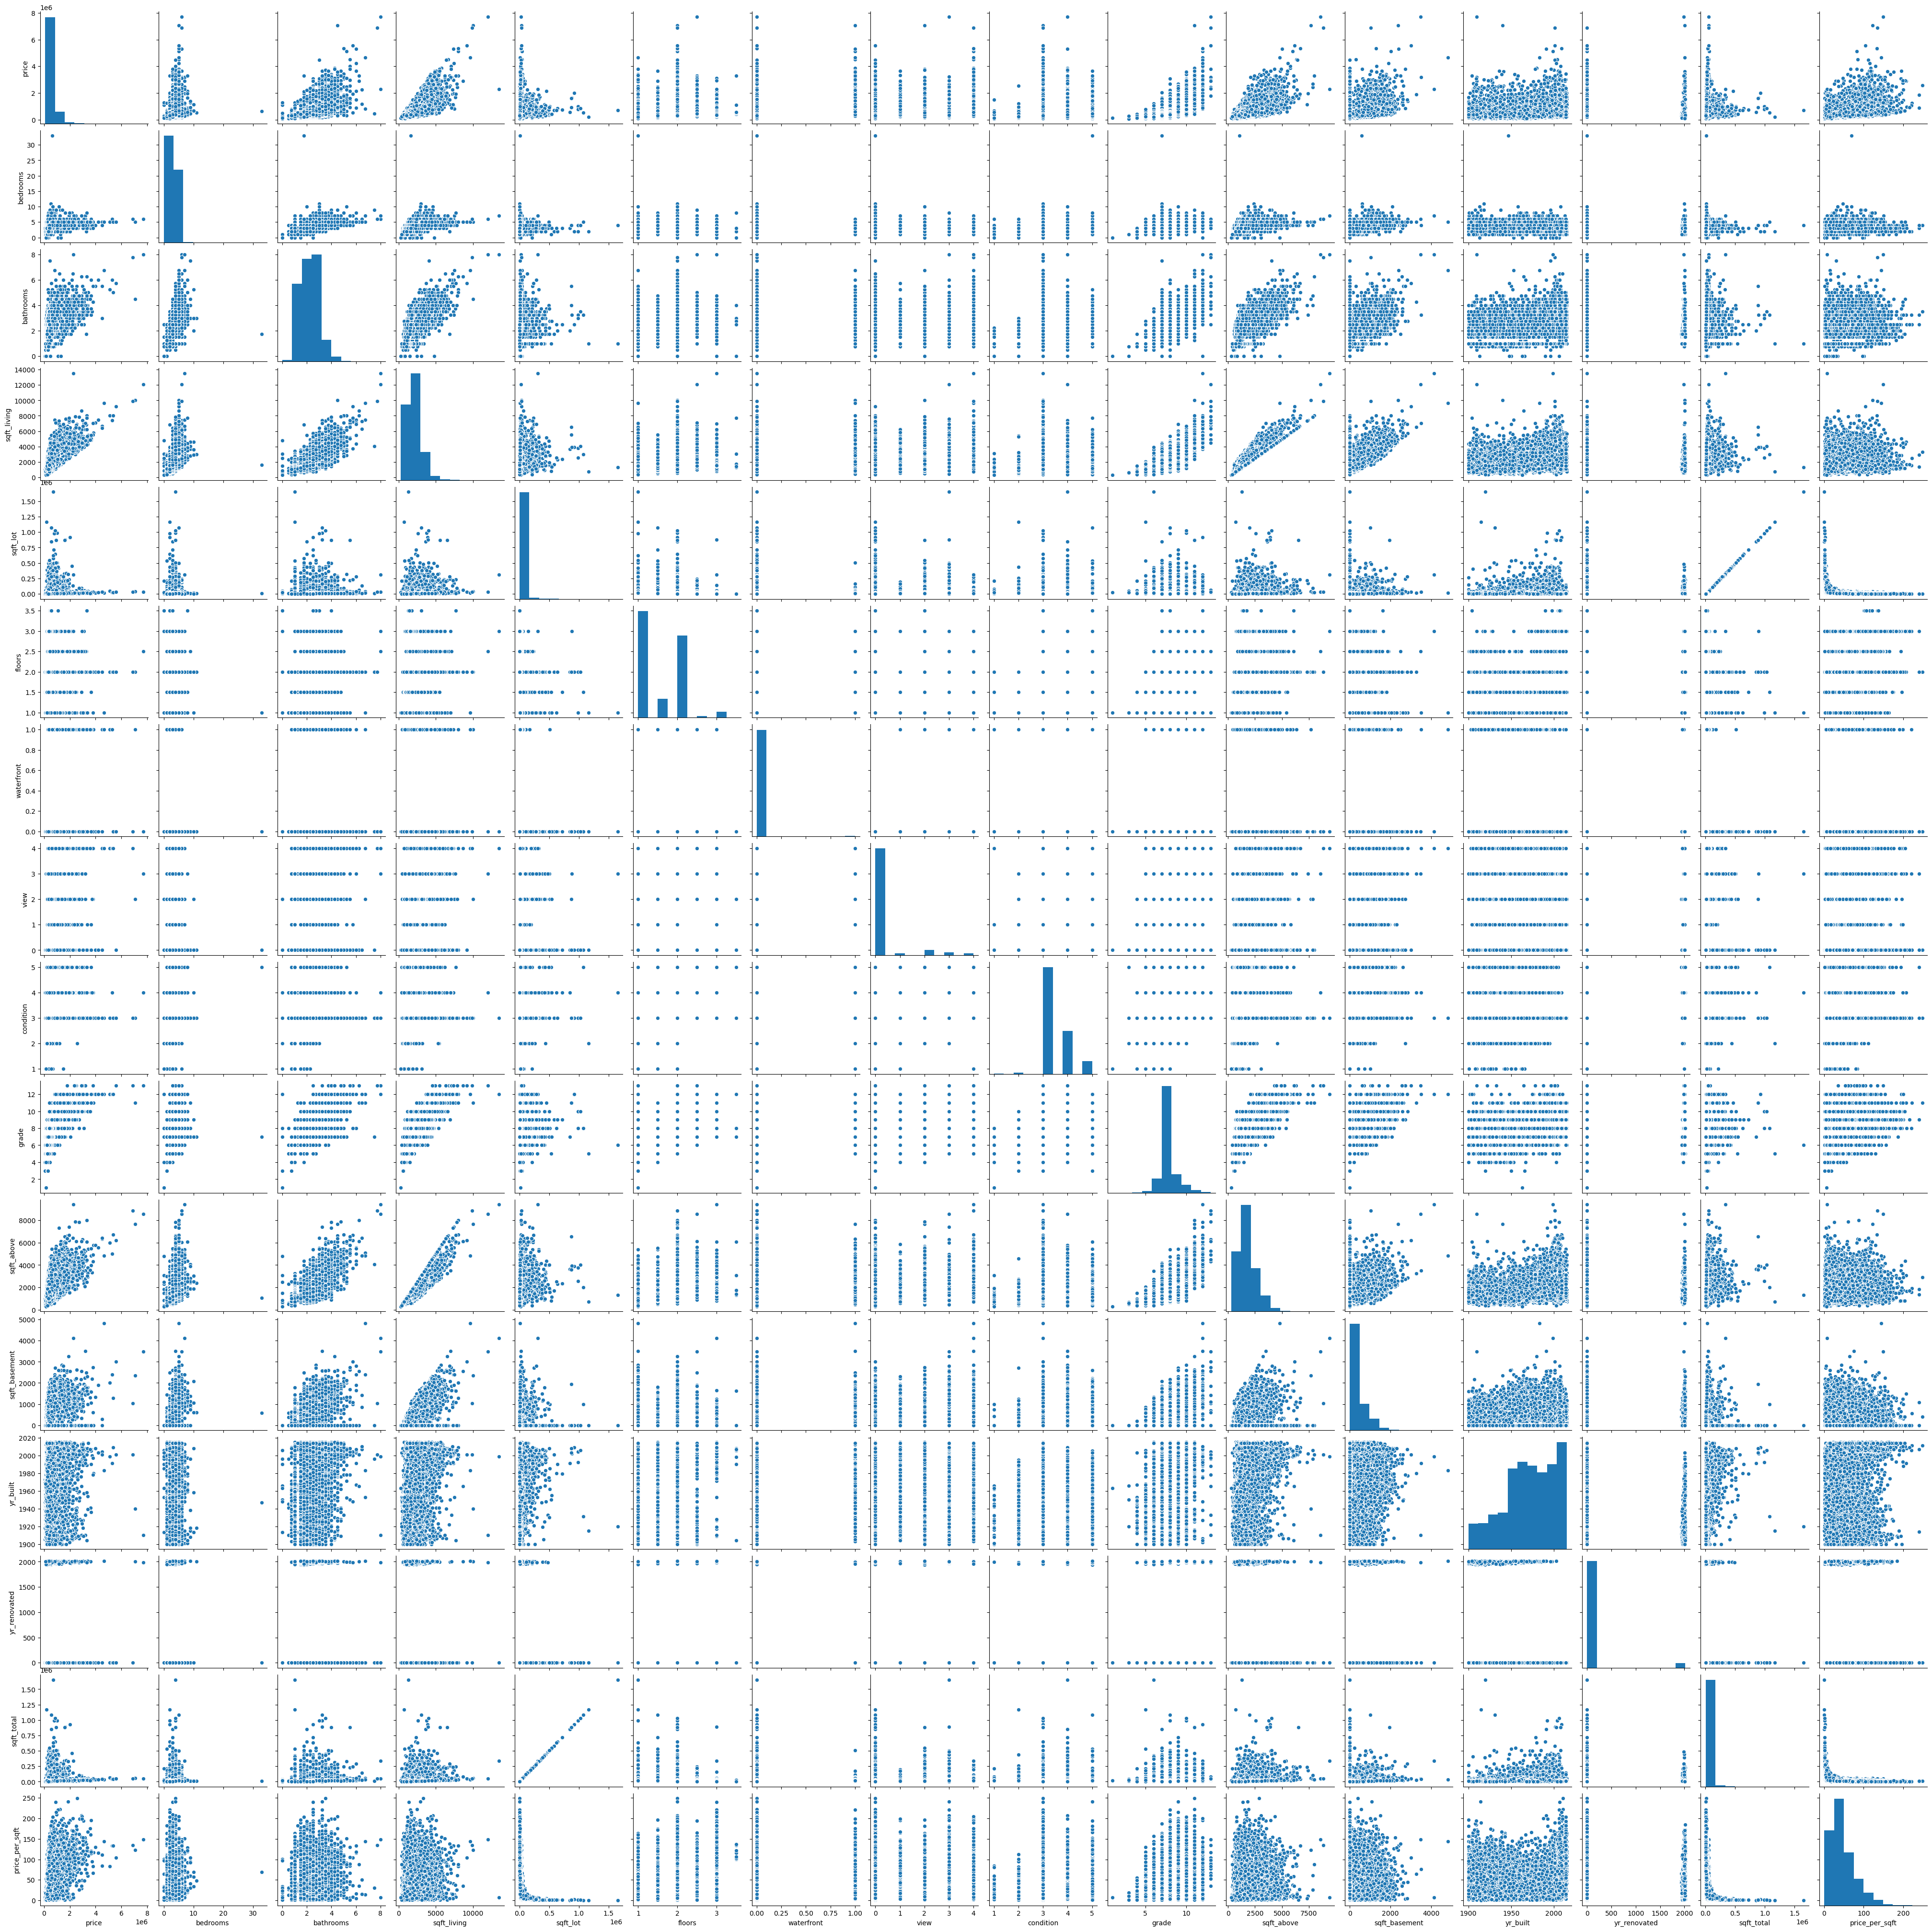

In [211]:
sns.pairplot(df)

In [24]:
df.drop(columns = ['sqft_living', 'sqft_lot', 'waterfront', 'view', 'sqft_above', 'sqft_basement', 'yr_renovated'], inplace = True)

In [25]:
df

price  bedrooms  bathrooms  floors  condition  grade  yr_built  \
0      221900.0         3       1.00     1.0          3      7      1955   
1      538000.0         3       2.25     2.0          3      7      1951   
2      180000.0         2       1.00     1.0          3      6      1933   
3      604000.0         4       3.00     1.0          5      7      1965   
4      510000.0         3       2.00     1.0          3      8      1987   
...         ...       ...        ...     ...        ...    ...       ...   
21608  360000.0         3       2.50     3.0          3      8      2009   
21609  400000.0         4       2.50     2.0          3      8      2014   
21610  402101.0         2       0.75     2.0          3      7      2009   
21611  400000.0         3       2.50     2.0          3      8      2004   
21612  325000.0         2       0.75     2.0          3      7      2008   

       sqft_total  price_per_sqft  
0            8010       27.702871  
1           12382       43.450170  
2           11540       15.597920  
3            8920       67.713004  
4           11440       44.580420  
...           ...             ...  
21608        4191       85.898354  
21609       10433       38.339883  
21610        3390      118.613864  
21611        5588       71.581961  
21612        3116      104.300385  

[21613 rows x 9 columns]

In [26]:
y = df['price']
X = df.drop('price', axis=1)

phrase_1 = "The shape of the y input label is {label} and the type is {type}.".format(label = y.shape, type = type(y))
phrase_2 = "The shape of the X dataframe is {label} and the type is {type}.".format(label = X.shape, type = type(X))

print(phrase_1)
print(phrase_2)

The shape of the y input label is (21613,) and the type is <class 'pandas.core.series.Series'>.
The shape of the X dataframe is (21613, 8) and the type is <class 'pandas.core.frame.DataFrame'>.


In [27]:
# Algorithm condition needed frequency of labels to be 2 or more. Therefore we create a groupby filter to drop based 
# on condition. 

df_sub = df.groupby('price').filter(lambda x : len(x)>2)
df_sub['price'].value_counts()

450000.0    172
350000.0    172
550000.0    159
500000.0    152
425000.0    150
           ... 
838000.0      3
436500.0      3
681000.0      3
822000.0      3
727000.0      3
Name: price, Length: 1190, dtype: int64

In [28]:
# create label and train set. 

y = df_sub['price']
X = df_sub.drop('price', axis = 1)

In [29]:
phrase_1 = "The shape of the y input label is {label} and the type is {type}.".format(label = y.shape, type = type(y))
phrase_2 = "The shape of the X dataframe is {label} and the type is {type}.".format(label = X.shape, type = type(X))

print(phrase_1)
print(phrase_2)

The shape of the y input label is (18332,) and the type is <class 'pandas.core.series.Series'>.
The shape of the X dataframe is (18332, 8) and the type is <class 'pandas.core.frame.DataFrame'>.


In [30]:
# train test split at 75 - 25 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 45, stratify = y)

In [31]:
# create a for loop to confirm our distributions. 
for dataset in [X_train, X_test]:
    print(round(len(dataset)/ len(y), 2))

0.75
0.25


# LOOK INTO STANDARD SCALER

Krish Naik, and other videos do feature selection based on metrics like MSE, R squared, correlation etc. 

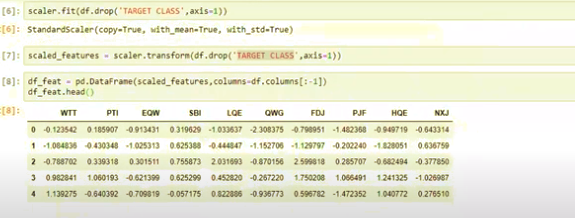

In [287]:
# creating a list comprehension removing rows that have a frequency of less than two. Convert list back to series. 

lst = (df['price'].tolist())
k = 2
res = [i for i in lst if lst.count(i) >= k]
y = pd.Series(res)

In [291]:
# randomly removing rows from the dataframe to make X and y have the same amount of rows. 

np.random.seed(10)
remove_n = 2395
drop_indices = np.random.choice(X.index, remove_n, replace=False)
X = X.drop(drop_indices)

In [296]:
# Because Train test split operates by accounting for the frequencies of numbers; the more frequent numbers in the set
# will be duplicated on the split. This leaves potential for less frequent numbers to be left our entirely. 
# Stratify parameter ensures that the number of unique values will match what is show in the y variable. 